## 코로나 데이터를 통해 알아보는 다양한 시각적 접근

### 1. 서론
---
<br>

- 코로나19와 함께 싸워온 지난 날들의 데이터를 바탕으로 초기 감염자가 바이러스를 확산해 가는 과정들을 분석하는데 초점을 맞추어보았습니다.

- 현재 우리나라뿐만 아니라 세계적으로 문제가 되고 있는 코로나 바이러스에 대한 시각화와 인사이트 분석을 통해 저희가 공부한 것을 적용해 보고자 하였습니다. 이번 프로젝트로 인해 데이터 시각화 여러 기술을 접해보고 오류도 해결해 나가면서 배운 것이 많습니다. 아직 많이 부족하지만, 나름대로 표현 하고자 했던 것을 그려놓았으니 재밌게 봐주시기 바랍니다 !

- 저희는 뉴스 데이터를 통해 코로나가 이슈화 되었던 시기와 코로나19 관련 키워드들 중에 이슈가 되는 키워드에 집중하여 접근하였습니다. 그리고 이어서 새로운 논점을 제시하여 이를 다양한 방법으로 표현하려고 하였습니다. 이 과정에서 저희는 초기집단 감염자들의 확산 루트와 파급력에 대해 집중하였는데, 이는 이슈화 되었던 시기의 패턴을 분석하여 집단감염을 예방하는데 도움을 줄 수 있을 것입니다. 또한 마스크 5부제와 사회적 거리두기 정책의 실행 전후에 코로나 확산이 어떻게 이루어졌는지 분석하면서 마무리하도록 하겠습니다.

In [ ]:
!pip install konlpy
!pip install bs4
!pip install pyecharts==0.5.11
# !pip install html_table_parser
# !pip uninstall bs4
# !pip install bs4==4.6.0
# from html_table_parser import parser_functions as parser

from pyecharts import Pie
import requests
from bs4 import BeautifulSoup
import re
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm  # 폰트 관련 용도
from matplotlib import rc
import numpy as np
from datetime import datetime
import seaborn as sns
import pandas as pd
import warnings
from urllib.request import urlopen
import json
import sqlite3
import datetime
from dateutil.relativedelta import relativedelta


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

ERROR:lml.utils:failed to import pyecharts_snapshot
Traceback (most recent call last):
  File "C:\Users\can34\anaconda3\lib\site-packages\lml\utils.py", line 43, in do_import
    plugin_module = __import__(plugin_module_name)
ModuleNotFoundError: No module named 'pyecharts_snapshot'


#### 1-1 코로나를 언급한 뉴스의 기사 건수를 그래프화 해보자

In [ ]:
path = r'./'
corona_news = pd.read_csv(path + "corona_news_count.csv")
corona_news_df = pd.pivot_table(corona_news, values='date', index=['date'])
corona_news_df

,count
date,
2020-01-01,0
2020-01-02,6
2020-01-03,9
2020-01-04,0
2020-01-05,1
...,...
2020-09-02,5333
2020-09-03,5104
2020-09-04,3825


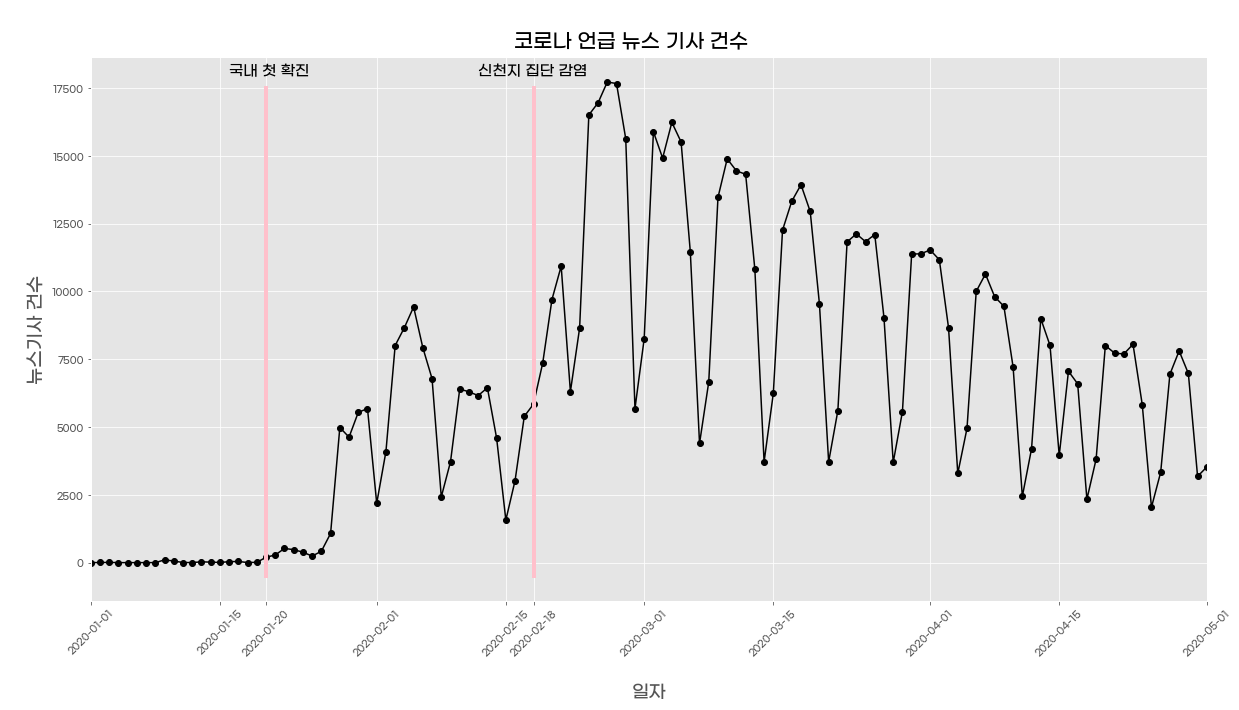

In [ ]:

path_gmarket = path +'GmarketSansTTFMedium.ttf'
font_gmarket = fm.FontProperties(fname=path_gmarket, size=16)
plt.style.use('ggplot')

fig = plt.figure(figsize=(20,10))
plt.plot(corona_news_df.index, corona_news_df, '-ok')
plt.plot([corona_news['date'][corona_news[corona_news['date']=='2020-01-20'].index[0]],
          corona_news['date'][corona_news[corona_news['date']=='2020-01-20'].index[0]]],
         [-500, 17500],
         lw=4,
         c='pink')
plt.plot([corona_news['date'][corona_news[corona_news['date']=='2020-02-18'].index[0]],
          corona_news['date'][corona_news[corona_news['date']=='2020-02-18'].index[0]]],
         [-500, 17500],
         lw=4,
         c='pink')

fig.suptitle('\n코로나 언급 뉴스 기사 건수', fontproperties=font_gmarket, fontsize=20, position=(0.5, 0.95))
plt.annotate('국내 첫 확진',[corona_news['date'][corona_news[corona_news['date']=='2020-01-20'].index[0]-4], 18000],fontsize=15, fontproperties=font_gmarket)
plt.annotate('신천지 집단 감염',[corona_news['date'][corona_news[corona_news['date']=='2020-02-18'].index[0]-6],18000],fontsize=15, fontproperties=font_gmarket)

plt.xticks(['2020-01-01', '2020-01-15', '2020-01-20', '2020-02-01', '2020-02-15', '2020-02-18', '2020-03-01', '2020-03-15', '2020-04-01', '2020-04-15', '2020-05-01', '2020-05-15', '2020-06-01', '2020-06-15', '2020-07-01', '2020-07-15', '2020-08-01', '2020-08-15', '2020-09-01'],
           rotation=45, fontproperties=font_gmarket, fontsize=10)
plt.yticks(fontproperties=font_gmarket, fontsize=10)

plt.xlabel('\n일자', fontproperties=font_gmarket, fontsize=18)
plt.ylabel('\n뉴스기사 건수', fontproperties=font_gmarket, fontsize=18)
plt.xlim(0, '2020-05-01')

plt.show()

- 데이터가 주기적으로 증감현상을 보이는 것은 주말휴일에 기사를 내지 않아서입니다.

#### 1-2. 1월부터 6월까지의 네이버 '많이 본 뉴스' 기사 제목에서 코로나 관련 핫 토픽을 알아보자

In [ ]:
day = 0
news_top_name = []
news_URL_list = []

for i in range(1, 9):
    month = '0'+str(i)


    if i%2 == 1 or i == 8:
        for x in range(1, 32):
            day += 1
            if day < 10:
                news_URL_list.append(f'https://news.naver.com/main/ranking/popularDay.nhn?rankingType=popular_day&sectionId=103&date=2020{month}0{day}')
            else:
                news_URL_list.append(f'https://news.naver.com/main/ranking/popularDay.nhn?rankingType=popular_day&sectionId=103&date=2020{month}{day}')
    elif i == 2:
        for y in range(1, 30):
            day += 1
            if day < 10:
                news_URL_list.append(f'https://news.naver.com/main/ranking/popularDay.nhn?rankingType=popular_day&sectionId=103&date=2020{month}0{day}')
            else:
                news_URL_list.append(f'https://news.naver.com/main/ranking/popularDay.nhn?rankingType=popular_day&sectionId=103&date=2020{month}{day}')
    else:
        for z in range(1, 31):
            day += 1
            if day < 10:
                news_URL_list.append(f'https://news.naver.com/main/ranking/popularDay.nhn?rankingType=popular_day&sectionId=103&date=2020{month}0{day}')
            else:
                news_URL_list.append(f'https://news.naver.com/main/ranking/popularDay.nhn?rankingType=popular_day&sectionId=103&date=2020{month}{day}')
    day = 0

for news_URL in news_URL_list:
  response = requests.get(news_URL, headers={"User-Agent": "Mozilla/5.0"})
  soup= BeautifulSoup(response.text, 'html.parser')
  news_top = soup.find_all('a', class_='nclicks(rnk.lif)')
  for i in news_top:
    p = re.compile(r"<a.+>(?P<name>.+)</a>")
    try:
        a = p.match(str(i)).group('name').replace('"', '').replace("'", '')
        news_top_name.append(a)

    except:
        pass

# print(news_top_name)

words = Okt().morphs(''.join(news_top_name))

In [ ]:
sw = ['\n','\r','.',',','’','…','\xa0','\t','‘','(',')',"'",'인','’(',
      '하는', '된다', '!', '한다', '하고', '도', '위해', '된', '날', '다', '있는',
      '고', '없는','TH','얻게되','날리아','줬으면',
      '이다','에서는','은','는','이', '있', '하', '것', '들', '그', '되', '수',
      '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때',
      '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것',
      '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더',
      '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키',
      '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월',
      '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀',
      '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전',
      '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하',
      '소리', '놓', '라는', '되어', '채', '온', '되는', '없이', '처럼', '하지', '점점',
      '에는', '했던', ').', '”', '이제', '그러던', '단', '뿐', '..', '이라는', '라',
      '않는', '인가', '’.', '통해', '않은', '건', '될', '인해', '“', '있던', '-',
      '기', '"', '에도', '),', '서', '하여', '와의', '<', '>', '처', '며', '음',
      '있다는', '만다', ':', '1', '2', '3', '존', '듯', '줄', '이를', '있을',
      '더욱', '치', '않고', '않고', '되면서', '엔', '니', '했다', '받고', '리',
      '’,', '이고', '받는다', '거', '마다', '곁', '땅', '에게도', '듣게', '10',
      '온다', '되지', '화려한', '랑', '력', '맨', '~', '직접', '느끼게', '란',
      '되었다', '10년', '서서히', '둔', '톰', '휘', "'.", '막', '전혀', '!!',
      '터', '최', '이며', '째', '폴', '?!', '현', '우', '노', '갈', '......',
      '7', '아직', '애',  ']', '이던', '석', '갖고', '린다' '이나', '아니라',
      '과는', '작', '찬', '있고', '”\xa0', '만큼', '이어', '에서의', '경',
      '권', '{', '낸', '1년', '무', '보지', '않다', '순', '\xa0', '모를', '트',
      '평범한', '새', '(?)', '라고', '아닌', '난', '연', '엄청난', '만의', '싶은',
      '빠진', '모르는', '특별한', '대신', '죽은', '있었다', '에서는', '준', '않는다',
      '당', '열', '마주', '하려는', '걸', '일까', '게', '으로부터', '잭', '진짜',
      '이라', '든', '잃고', '히', '스', '달리', '완벽한', '이상한', '미', '씩',
      '떠난다', '즈', '이라고', '대해', '해야', '이미', '무사히', '만이', '받아',
      ')’','임','였던','번째','가는','에게는','한다는','하자','하자','하면','요',
      '에서도','통','로서','6','되지만', '5','하려','만을','...',"'(",'바','만에',
      '닉','린','에게서','하기로','호','마리','해서','되자','에겐','에게도','듣게',
      '아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라',
      '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다',
      '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면',
      '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론',
      '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다',
      '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만',
      '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면',
      '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로',
      '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야',
      '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서',
      '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만',
      '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지',
      '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다',
      '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그',
      '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓',
      '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만',
      '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면',
      '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로', '바꾸어서 말하면',
      '바꾸어서 한다면', '만약', '그렇지않으면', '까악', '툭', '딱', '삐걱거리다',
      '보드득', '비걱거리다', '꽈당', '응당', '해야한다', '에 가서', '각', '각각',
      '여러분', '각종', '각자', '제각기', '하도록하다', '와', '과', '그러므로', '그래서',
      '고로', '한 까닭에', '하기 때문에', '거니와', '이지만', '대하여', '관하여', '관한',
      '과연', '실로', '아니나다를가', '생각한대로', '진짜로', '한적이있다', '하곤하였다',
      '하', '하하', '허허', '아하', '거바', '와', '오', '왜', '어째서', '무엇때문에',
      '어찌', '하겠는가', '무슨', '어디', '어느곳', '더군다나', '하물며', '더욱이는',
      '어느때', '언제', '야', '이봐', '어이', '여보시오', '흐흐', '흥', '휴', '헉헉',
      '헐떡헐떡', '영차', '여차', '어기여차', '끙끙', '아야', '앗', '아야', '콸콸',
      '졸졸', '좍좍', '뚝뚝', '주룩주룩', '솨', '우르르', '그래도', '또', '그리고',
      '바꾸어말하면', '바꾸어말하자면', '혹은', '혹시', '답다', '및', '그에 따르는',
      '때가 되어', '즉', '지든지', '설령', '가령', '하더라도', '할지라도', '일지라도',
      '지든지', '몇', '거의', '하마터면', '인젠', '이젠', '된바에야', '된이상',
      '만큼\t어찌됏든', '그위에', '게다가', '점에서 보아', '비추어 보아', '고려하면',
      '하게될것이다', '일것이다', '비교적', '좀', '보다더', '비하면', '시키다', '하게하다',
      '할만하다', '의해서', '연이서', '이어서', '잇따라', '뒤따라', '뒤이어', '결국',
      '의지하여', '기대여', '통하여', '자마자', '더욱더', '불구하고', '얼마든지', '마음대로',
      '주저하지 않고', '곧', '즉시', '바로', '당장', '하자마자', '밖에 안된다', '하면된다',
      '그래', '그렇지', '요컨대', '다시 말하자면', '바꿔 말하면', '즉', '구체적으로',
      '말하자면', '시작하여', '시초에', '이상', '허', '헉', '허걱', '바와같이', '해도좋다',
      '해도된다', '게다가', '더구나', '하물며', '와르르', '팍', '퍽', '펄렁', '동안', '이래',
      '하고있었다', '이었다', '에서', '로부터', '까지', '예하면', '했어요', '해요', '함께',
      '같이', '더불어', '마저', '마저도', '양자', '모두', '습니다', '가까스로', '하려고하다',
      '즈음하여', '다른', '다른 방면으로', '해봐요', '습니까', '했어요', '말할것도 없고',
      '무릎쓰고', '개의치않고', '하는것만 못하다', '하는것이 낫다', '매', '매번', '들',
      '모', '어느것', '어느', '로써', '갖고말하자면', '어디', '어느쪽', '어느것', '어느해',
      '어느 년도', '라 해도', '언젠가', '어떤것', '어느것', '저기', '저쪽', '저것',
      '그때', '그럼', '그러면', '요만한걸', '그래', '그때', '저것만큼', '그저',
      '이르기까지', '할 줄 안다', '할 힘이 있다', '너', '너희', '당신', '어찌', '설마',
      '차라리', '할지언정', '할지라도', '할망정', '할지언정', '구토하다', '게우다', '토하다',
      '메쓰겁다', '옆사람', '퉤', '쳇', '의거하여', '근거하여', '의해', '따라', '힘입어',
      '그', '다음', '버금', '두번째로', '기타', '첫번째로', '나머지는', '그중에서',
      '견지에서', '형식으로 쓰여', '입장에서', '위해서', '단지', '의해되다', '하도록시키다',
      '뿐만아니라', '반대로', '전후', '전자', '앞의것', '잠시', '잠깐', '하면서', '그렇지만',
      '다음에', '그러한즉', '그런즉', '남들', '아무거나', '어찌하든지', '같다', '비슷하다',
      '예컨대', '이럴정도로', '어떻게', '만약', '만일', '위에서 서술한바와같이', '인 듯하다',
      '하지 않는다면', '만약에', '무엇', '무슨', '어느', '어떤', '아래윗', '조차', '한데',
      '그럼에도 불구하고', '여전히', '심지어', '까지도', '조차도', '하지 않도록', '않기 위하여',
      '때', '시각', '무렵', '시간', '동안', '어때', '어떠한', '하여금', '네', '예',
      '우선', '누구', '누가 알겠는가', '아무도', '줄은모른다', '줄은 몰랏다', '하는 김에',
      '겸사겸사', '하는바', '그런 까닭에', '한 이유는', '그러니', '그러니까', '때문에',
      '그', '너희', '그들', '너희들', '타인', '것', '것들', '너', '위하여', '공동으로',
      '동시에', '하기 위하여', '어찌하여', '무엇때문에', '붕붕', '윙윙', '나', '우리',
      '엉엉', '휘익', '윙윙', '오호', '아하', '어쨋든', '만 못하다\t하기보다는', '차라리',
      '하는 편이 낫다', '흐흐', '놀라다', '상대적으로 말하자면', '마치', '아니라면', '쉿',
      '그렇지 않으면', '그렇지 않다면', '안 그러면', '아니었다면', '하든지', '아니면',
      '이라면', '좋아', '알았어', '하는것도', '그만이다', '어쩔수 없다', '하나', '일',
      '일반적으로', '일단', '한켠으로는', '오자마자', '이렇게되면', '이와같다면', '전부',
      '한마디', '한항목', '근거로', '하기에', '아울러', '하지 않도록', '않기 위해서',
      '이르기까지', '이 되다', '로 인하여', '까닭으로', '이유만으로', '이로 인하여', '그래서',
      '이 때문에', '그러므로', '그런 까닭에', '알 수 있다', '결론을 낼 수 있다', '으로 인하여',
      '있다', '어떤것', '관계가 있다', '관련이 있다', '연관되다', '어떤것들', '에 대해',
      '이리하여', '그리하여', '여부', '하기보다는', '하느니', '하면 할수록', '운운',
      '이러이러하다', '하구나', '하도다', '다시말하면', '다음으로', '에 있다',
      '에 달려 있다', '우리', '우리들', '오히려', '하기는한데', '어떻게', '어떻해',
      '어찌됏어', '어때', '어째서', '본대로', '자', '이', '이쪽', '여기', '이것',
      '이번', '이렇게말하자면', '이런', '이러한', '이와 같은', '요만큼', '요만한 것',
      '얼마 안 되는 것', '이만큼', '이 정도의', '이렇게 많은 것', '이와 같다', '이때',
      '이렇구나', '것과 같이', '끼익', '삐걱', '따위', '와 같은 사람들', '부류의 사람들',
      '왜냐하면', '중의하나', '오직', '오로지', '에 한하다', '하기만 하면', '도착하다',
      '까지 미치다', '도달하다', '정도에 이르다', '할 지경이다', '결과에 이르다',
      '관해서는', '여러분', '하고 있다', '한 후', '혼자', '자기', '자기집', '자신',
      '우에 종합한것과같이', '총적으로 보면', '총적으로 말하면', '총적으로', '대로 하다',
      '으로서', '참', '그만이다', '할 따름이다', '쿵', '탕탕', '쾅쾅', '둥둥', '봐',
      '봐라', '아이야', '아니', '와아', '응', '아이', '참나', '년', '월', '일', '령',
      '영', '일', '이', '삼', '사', '오', '육', '륙', '칠', '팔', '구', '이천육',
      '이천칠', '이천팔', '이천구', '하나', '둘', '셋', '넷', '다섯', '여섯', '일곱',
      '여덟', '아홉', '령', '영', '없고', '없었던', '들고', '/', '간의', '[',
      '....', '들이', '안나', '낼', '빈', '윌', '에선', '먼저', '보게', '있지만',
      '했지만', '심', '와는', '가고', '잡', '가고', '모른', '잡', '않게', '20',
      '개월', '어릴', '8', '으론','하느라','이었을까','섞인','는다','아닐까','가며',
      '있어도','기다리는데','주겠다는','was','by','나눠','만드는데','필요하다는','알린다',
      '모인다',"?’", '했다는', '거듭', 'A', '당한', '로벝', '찾을', '가는데', '갑작스런',
      '치고', '넘치는', '사라', '꼭', '앤', '프랭크', '나선', '왔던', '찾은', '척',
      '시킨다', '온갖', '아는', '태어난', '강한', '깨닫게', '데리', '느끼고', '주는',
      '둘러싼', '크리스', '로운', '만은', '걸려', '옆', '떠나게', '스러운', '케이트',
      '부른','가져','U','찍어','알아보지','열두','커녕','부턴','지켜본','말고','프라',
      '바니','자도','미진','새미','싸울','미사','먹어','진의','알면서도','이르고',
      'C','민아', '움', '어쩔', '올', '드', '벤', '안고', '님', '들어', '였다',
      '3년', '`', '불러', '받으며', '있는데', '용', '친', '제이', '나를', '너무나',
      '보내던', '하러', '있어', '없다는', '오래', '9', '데이빗', '닮은', '다니엘',
      '남겨진', '인데', '박', '김', '앙숙','치코','던진다','야하는','했으나','차게',
      '믿으며','건지','진다','푹','엘리자','쩍','드러나게','불타','모여든다','주리','고리',
      '보려','for','from', "',", '거기', '이는', '래', '접', '맘', '이의', '가던',
      '에밀리', '쟁이', '마틴', '\xa0', '이든', '해야만', '30', '보면', '수록', '봉',
      '보내게', '싶어', '18', '되면', '’!', '거야', '나타나고', '한테', '스틴', '또다시',
      '놓고', '대니', '15년', '합니다', '이드', 'xa0\xa0“', '에디', '찾던', '치는',
      '케', '얻은', '받지', '3일', '숨겨져', '유키', '얻기', '드러내는','보내는데',
      '되려는','미는','돌아오게','느끼는데','빨려','받으면서','매몰','들어갈','있을지',
      '였고','뿐인','커져','보여주고','하는가','드는데','튀는','찍힌','.....','내려오는',
      '일으켜','시키는데','넘어가', '무언가', '새로', '케이', '없던', '어느새', '언',
      '빌', '만나고', '족', '갈수록', '만드는', '얻게', '제이슨', '시킨', '갖게',
      '생긴', '먹고', '하려고', '맡게', '그로', '말리', '며칠', '들은', '토니', '와중',
      '2년', '뜻밖', 'of', '시켜', '.)', '함', 'to', '클', '가기', '디', '입은', '뭐',
      '폭','젤','힐','거머','준다는','차린','찾아가고','해왔던','상관없이','꺼내','that',
      '그렇다면','들어가고','빠져있는','보던','코스','싣고','라일','고단','벼랑','되길',
      '들여','여기저기','취하','발레리','만나지만','첸','모종','주요','벅','지환','슨',
      '보니', '리스', 'a', '아주', '돼', '녀', '커', '&', '제인', '7년', '...!',
      '두운', '민', '않을', '지는', '긴', ")'", '시키고', '루이스', '쳐', '오는',
      '빠지고', '여러', '않았던', '오게', '모르게', '해도', '해온', '없을', '지미',
      '엘', '짓', '걷', '꾼', '뺨','십','들러','톤','오브','스토','리언','한자리','것임',
      '찾아가게','뜻대로','주며','보내며','단번','건의','해달라고','리드','톱','예요',
      '감도는','꾸리','희는', '스럽게', '수가', '모아', '만든다', '론', '헨리', '걸까',
      '걸까', '않아', '탄', '입니다', '죠', 'and', '메이', '아니다', '라도', '메',
      'D', '해주는', '그대로', '해서는', '레오', '라며', '나온', '와', '테', '브라이언',
      '수진', '나서는데', '이른다', '나와', '밑', '사사건건', '유', '제이크', '라이언',
      '루시', '12', "',", '루', 'J','용호','끌림을','꾸며','남긴다','엎친',
      '지키며','맴도','않았지만','보일','지낸','처분','각지','잦은','각지','이뤄','랄',
      '..."','지오','가도','어울려','시키며','핀', '따로','날로','레나','받아야','이었다는',
      '되게','프레','나타나면서','크고','해가는','피어','타기','서야','않나','뎁','근데',
      '그루','아니었다','당하던','들으며','적은','작고','.(','사가','?','되고','할','못','하게','되는데','해',
      '하는데','하기','많이','뭐야','곧','\xa0\xa0','모든','세','하며','하던'
      '분','만','곳','코','아무','하다','받게','반','후','같은','대', '｜', '···', '·', '…[', '4', '확']
sw_removed = []
for i in words:
    if i.lower() not in sw:
        sw_removed.append(i)
# print(sw_removed)
count_list = Counter(sw_removed)
print(count_list)

Counter({'코로나': 544, '이유': 226, '신천지': 225, '19': 221, '속보': 219, '논란': 217, '한국': 182, '마스크': 163, '종합': 160, '단독': 154, '더오래': 148, '차': 137, '진자': 136, '비': 131, '세계': 131, '확진': 127, '교회': 126, '부부': 125, '?…': 123, '배우': 117, '감염': 115, '태풍': 114, '기생충': 100, '여성': 96, '트롯': 96, '오늘': 96, '건강': 95, '위': 95, '공개': 92, '사과': 90, '가족': 90, '뉴스': 89, '예배': 89, '전국': 87, '보다': 86, ';': 86, '서울': 86, '방송': 85, '?[': 83, '간': 83, '첫': 82, '남편': 81, '미스터': 80, 'KBS': 76, '법': 75, '사망': 74, '운동': 74, '이만': 74, '80': 73, '전문': 73, '결혼': 72, '현대차': 72, '희': 72, '엄마': 71, '장': 70, '상': 68, '날씨': 67, '딸': 66, '’…': 66, '영상': 65, '폭로': 65, '내일': 65, '정부': 64, '여행': 63, '국내': 63, '봉준호': 62, '하루': 61, '성': 61, '환자': 61, '아들': 60, '격리': 59, '뒤': 59, '대구': 59, '사랑': 58, '계': 58, '의혹': 58, '제네시스': 57, '중단': 57, '없다': 57, '급': 57, '이태원': 57, '남자': 56, '우한': 56, '잇': 56, '총': 56, '세상': 55, '다이어트': 55, '면': 54, '→': 54, '달': 53, '아나운서': 53, '中': 53, '병원': 53, '하차': 52, '가수': 52, '가장': 52, '최고': 52, '이혼

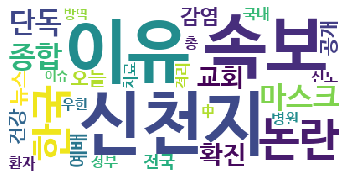

In [ ]:
#코로나 관련 키워드로 뽑아 워드클라우드 시각화하기
count_list_cov19 = {'이유': 226, '신천지': 225,'속보': 219, '논란': 217, '한국': 182, '마스크': 163,
                    '종합': 160, '단독': 154, '확진': 127, '교회': 126,'감염': 115,'오늘': 96, '건강': 95, '공개': 92,
                    '뉴스': 89, '예배': 89, '전국': 87, '정부': 64, '국내': 63, '환자': 61, '격리': 59, '우한': 56,
                    '총': 56,'中': 53,'병원': 53, '치료': 52, '신도': 52, '방역': 49,'이슈': 48}
my_wc = WordCloud(font_path= path + 'NanumBarunGothicBold.ttf', background_color='white')
plt.imshow(my_wc.generate_from_frequencies(count_list_cov19))
plt.axis('off')
plt.show()

### 1-3. 가장 크게 보이는 '신천지'와 '코로나'는 우리나라 사람들에게 얼마나 많은 관심을 받았는지 알 수 있다.
- 그만큼 코로나의 확산에 신천지의 영향력이 컸다는 것을 보여준다.
- 신천지의 초기 발생지인 대구의 지역감염에서 전국적인 확산으로 어떻게 발전했는지 알아보자.

### 2-1. 대구지역에서 있었던 초기 감염자를 찾아보자.

In [ ]:
region = pd.read_csv(path+"Region.csv")
patientinfo = pd.read_csv(path+"Patientinfo.csv")
patientroute = pd.read_csv(path +"PatientRoute.csv")
case =  pd.read_csv(path + "Case.csv")
df_info = pd.DataFrame(patientinfo)
df_region = pd.DataFrame(region)

In [ ]:
plt.rc('font',family='Malgun Gothic')
info_31 = patientinfo[patientinfo['patient_id']==1200000031]
info_31['city'] = 'Daegu'
info_31

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1007,1200000031,31.0,female,1959,60s,Korea,Daegu,Daegu,NaN,Shincheonji Church,NaN,NaN,1160,NaN,2020-02-18,NaN,NaN,isolated


In [ ]:
info_31_loc = pd.merge(region, info_31, on=['city','province'])
home_31 = info_31_loc[['latitude', 'longitude']]
home_31

,latitude,longitude
0,35.87215,128.601783


In [ ]:
route_31 = patientroute[patientroute['patient_id']==1200000031].reset_index()
route_31

,index,patient_id,global_num,date,province,city,type,latitude,longitude
0,4868,1200000031,31.0,2020-02-06,Daegu,Dong-gu,etc,35.886601,128.635302
1,4869,1200000031,31.0,2020-02-07,Daegu,Suseong-gu,hospital,35.858391,128.635214
2,4870,1200000031,31.0,2020-02-07,Daegu,Suseong-gu,hospital,35.858391,128.635214
3,4871,1200000031,31.0,2020-02-08,Daegu,Suseong-gu,hospital,35.858391,128.635214
4,4872,1200000031,31.0,2020-02-09,Daegu,Nam-gu,church,35.841206,128.598243
5,4873,1200000031,31.0,2020-02-09,Daegu,Nam-gu,etc,35.839717,128.566574
6,4874,1200000031,31.0,2020-02-09,Daegu,Suseong-gu,hospital,35.858391,128.635214
7,4875,1200000031,31.0,2020-02-09,Daegu,Suseong-gu,hospital,35.858391,128.635214
8,4876,1200000031,31.0,2020-02-15,Daegu,Dong-gu,lodging,35.882352,128.662133
9,4877,1200000031,31.0,2020-02-15,Daegu,Suseong-gu,hospital,35.858391,128.635214


In [ ]:
route_31_pos = route_31[['latitude', 'longitude']]
route_31_pos

,latitude,longitude
0,35.886601,128.635302
1,35.858391,128.635214
2,35.858391,128.635214
3,35.858391,128.635214
4,35.841206,128.598243
5,35.839717,128.566574
6,35.858391,128.635214
7,35.858391,128.635214
8,35.882352,128.662133
9,35.858391,128.635214


In [ ]:
import folium
from folium import plugins
map_data = folium.Map([35.765788, 128.619197], zoom_start=10)
lines = route_31_pos.values[:].tolist()

folium.PolyLine(
    locations=lines,
    fill=True,
    color='orange').add_to(map_data)

map_data

- 31번 확진자가 이동한 동선을 영역으로 시각화하였습니다.

In [ ]:
# 31번 확진자로 인해 감염된 사람들 리스트
infected_31 = patientinfo[(patientinfo['infected_by']=='1200000031')].reset_index()
infected_31['city'] = infected_31['city'].fillna('Daegu')
infected_31

,index,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1008,1200000033,33.0,female,1980,40s,Korea,Daegu,Jung-gu,NaN,contact with patient,NaN,1200000031,NaN,NaN,2020-02-18,NaN,NaN,isolated
1,1018,1200000047,47.0,female,1957,60s,Korea,Daegu,Daegu,NaN,Shincheonji Church,NaN,1200000031,NaN,NaN,2020-02-19,NaN,NaN,isolated
2,1019,1200000048,48.0,female,1948,70s,Korea,Daegu,Daegu,NaN,Shincheonji Church,NaN,1200000031,NaN,NaN,2020-02-19,NaN,NaN,isolated
3,1020,1200000049,49.0,male,1962,50s,Korea,Daegu,Daegu,NaN,Shincheonji Church,NaN,1200000031,NaN,NaN,2020-02-19,NaN,NaN,isolated
4,1021,1200000050,50.0,male,1944,70s,Korea,Daegu,Daegu,NaN,Shincheonji Church,NaN,1200000031,NaN,NaN,2020-02-19,2020-03-02,NaN,released
5,1022,1200000051,51.0,female,1959,60s,Korea,Daegu,Daegu,NaN,Shincheonji Church,NaN,1200000031,NaN,NaN,2020-02-19,2020-02-26,NaN,released
6,1346,1500000015,4996.0,male,NaN,20s,Korea,Daejeon,Yuseong-gu,NaN,contact with patient,NaN,1200000031,12,NaN,2020-03-03,2020-03-11,NaN,released
7,1382,1600000005,NaN,male,1999,20s,Korea,Ulsan,Nam-gu,NaN,Shincheonji Church,NaN,1200000031,NaN,2020-02-18,2020-02-26,2020-03-10,NaN,released
8,1489,2000000013,140.0,female,1988,30s,Korea,Gyeonggi-do,Gimpo-si,NaN,contact with patient,NaN,1200000031,NaN,2020-02-20,2020-02-21,NaN,NaN,isolated
9,1491,2000000015,246.0,female,1982,30s,Korea,Gyeonggi-do,Bucheon-si,NaN,contact with patient,NaN,1200000031,NaN,NaN,2020-02-22,NaN,NaN,isolated


In [ ]:
merge_df = pd.merge(df_region, infected_31, on=['city','province'])
result = merge_df[['latitude', 'longitude']]
result_lines = result.values[:].tolist()

In [ ]:
map_count = folium.Map([36.4, 128], zoom_start=7)

plugins.MousePosition().add_to(map_count)
plugins.MarkerCluster(result).add_to(map_count)

folium.PolyLine(
    locations=result_lines,
    color='orange').add_to(map_count)

folium.CircleMarker(
    home_31,
    radius=10,
    fill_color='red',
    color='red',
    weight=7).add_to(map_count)

map_count

- 31번 확진자가 빨간색으로 표시되어있고 31번 확진자가 감염시킨 사람들을 이어놓은 그래프 시각화입니다.

- 시각화 자료에서 숫자는 해당 지역 주변에 거주하는 확진자 수이며, 파란 핀의 아이콘은 거주하는 확진자 수가 한 명일때의 표시입니다.

### 2-2. 신천지로 인한 대구 내 지역감염을 시각화를 해보자.

In [ ]:
import folium
from folium import plugins

In [ ]:
region = pd.read_csv(path+"Region.csv")
patientinfo = pd.read_csv(path+"Patientinfo.csv")
patientroute = pd.read_csv(path +"PatientRoute.csv")
case =  pd.read_csv(path + "Case.csv")

In [ ]:
case.head()
df_case = case[case["group"] == True]
case[case["infection_case"] == "etc"]

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
18,1000019,Seoul,-,False,etc,38.0,-,-
28,1100010,Busan,-,False,etc,30.0,-,-
38,1200010,Daegu,-,False,etc,737.0,-,-
42,1300004,Gwangju,-,False,etc,0.0,-,-
49,1400007,Incheon,-,False,etc,6.0,-,-
55,1500006,Daejeon,-,False,etc,9.0,-,-
59,1600004,Ulsan,-,False,etc,7.0,-,-
65,1700006,Sejong,-,False,etc,1.0,-,-
77,2000012,Gyeonggi-do,-,False,etc,50.0,-,-
83,3000006,Gangwon-do,-,False,etc,7.0,-,-


- etc(기타등등)의 집담감염은 전부 FLASE이므로 비집단감염이다.


In [ ]:
case[case["infection_case"] == "contact with patient"]

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
17,1000018,Seoul,-,False,contact with patient,18.0,-,-
27,1100009,Busan,-,False,contact with patient,18.0,-,-
37,1200009,Daegu,-,False,contact with patient,920.0,-,-
41,1300003,Gwangju,-,False,contact with patient,1.0,-,-
48,1400006,Incheon,-,False,contact with patient,6.0,-,-
54,1500005,Daejeon,-,False,contact with patient,8.0,-,-
58,1600003,Ulsan,-,False,contact with patient,3.0,-,-
64,1700005,Sejong,-,False,contact with patient,3.0,-,-
76,2000011,Gyeonggi-do,-,False,contact with patient,53.0,-,-
82,3000005,Gangwon-do,-,False,contact with patient,0.0,-,-


- contact with patient의 집담감염은 전부 FLASE이므로 비집단감염이다.

In [ ]:
result = pd.merge(patientinfo,patientroute, on=['city','province'])
result

,patient_id_x,global_num_x,sex,birth_year,age,country,province,city,disease,infection_case,...,confirmed_date,released_date,deceased_date,state,patient_id_y,global_num_y,date,type,latitude,longitude
0,1000000001,2.0,male,1964,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,2020-01-23,2020-02-05,NaN,released,1000000055,1567.0,2020-02-19,hospital,37.548035,126.870758
1,1000000001,2.0,male,1964,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,2020-01-23,2020-02-05,NaN,released,1000000055,1567.0,2020-02-19,store,37.554032,126.871799
2,1000000001,2.0,male,1964,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,2020-01-23,2020-02-05,NaN,released,1000000055,1567.0,2020-02-20,store,37.554032,126.871799
3,1000000001,2.0,male,1964,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,2020-01-23,2020-02-05,NaN,released,1000000055,1567.0,2020-02-24,store,37.554032,126.871799
4,1000000001,2.0,male,1964,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,2020-01-23,2020-02-05,NaN,released,1000000055,1567.0,2020-02-25,store,37.554032,126.871799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341850,6100000089,NaN,male,1960,60s,Korea,Gyeongsangnam-do,Haman-gun,NaN,etc,...,2020-03-23,NaN,NaN,released,6100000089,NaN,2020-03-21,etc,35.333368,128.497988
341851,6100000089,NaN,male,1960,60s,Korea,Gyeongsangnam-do,Haman-gun,NaN,etc,...,2020-03-23,NaN,NaN,released,6100000089,NaN,2020-03-22,hospital,35.275725,128.410312
341852,6100000106,NaN,male,1993,20s,Korea,Gyeongsangnam-do,Sacheon-si,NaN,overseas inflow,...,2020-04-02,NaN,NaN,released,3001000004,NaN,2020-02-28,store,35.086187,128.089653
341853,6100000108,NaN,male,2004,10s,Korea,Gyeongsangnam-do,Sacheon-si,NaN,overseas inflow,...,2020-04-04,NaN,NaN,released,3001000004,NaN,2020-02-28,store,35.086187,128.089653


In [ ]:
subset = pd.DataFrame(result[['province','city', 'latitude', 'longitude','infection_case']])
subset.head()
#1 subset = [(시,도), 도시, 위도, 경도, 감염 요인]
sigungu_count = result[['latitude','longitude']].dropna()
sigungu_count.head()

,latitude,longitude
0,37.548035,126.870758
1,37.554032,126.871799
2,37.554032,126.871799
3,37.554032,126.871799
4,37.554032,126.871799


In [ ]:
#2-2 대구 지역 감염 원인 순위
# 대구 지역은 etc가 많은 것으로 보아 정확한 감염 원인 분석이 이루어지지 않은 것으로 보인다.
subset_DaeguGyeongbuk = pd.DataFrame(subset[(subset.province =='Daegu')])
subset_DaeguGyeongbuk = subset_DaeguGyeongbuk.reset_index()
subset_DaeguGyeongbuk['infection_case'].value_counts()

Shincheonji Church      220
contact with patient    124
Name: infection_case, dtype: int64

In [ ]:
#2-3 지도에 표시하기 위해 위도, 경도, 감염 요인으로 데이터 추출
# 감염 요인의 경우의 수를 count (같은 위도와 경도별로)
df_map = subset_DaeguGyeongbuk.groupby(["latitude", "longitude",'infection_case']).size().reset_index(name="count")
idx_num = df_map[df_map["count"] == 96].index
df_edit_map = df_map.drop(idx_num).reset_index()

In [ ]:
#2-4 색깔 지정 (신천지로 인한 감염 - darkblue)
df_edit_map['color']=0
for x in range(len(df_edit_map)):
    if (df_edit_map['infection_case'][x] == 'Shincheonji Church'):
        df_edit_map['color'][x] = 'darkblue'
    #신천지가 감염경로가 아닌 지역들은 투명한 색생으로 표시
    else:
        df_edit_map['color'][x] = 'red'
#     else:
#         df_map['color'][x] = 'red'   # 미확인(etc)
df_edit_map

,index,latitude,longitude,infection_case,count,color
0,0,35.819524,128.538869,Shincheonji Church,2,darkblue
1,1,35.829856,128.532758,Shincheonji Church,4,darkblue
2,2,35.832947,128.554406,Shincheonji Church,2,darkblue
3,3,35.836736,128.557796,Shincheonji Church,9,darkblue
4,4,35.838550,128.560505,Shincheonji Church,3,darkblue
...,...,...,...,...,...,...
58,60,35.871516,128.595943,contact with patient,3,red
59,61,35.873352,128.599876,Shincheonji Church,1,darkblue
60,62,35.873352,128.599876,contact with patient,1,red
61,63,35.877879,128.583280,Shincheonji Church,1,darkblue


In [ ]:
#2-6 우리나라 신천지 감염 구역 시각화
# 대구지역과 인근 지역에 주로 밀집해서 표현되는 것을 볼 수 있다.
Daegu_map = folium.Map(location=[35.845046, 128.598141], tiles="cartodbpositron", zoom_start=13)
for x in range(len(df_edit_map)):
    location = [df_edit_map['latitude'][x],df_edit_map['longitude'][x]]
    radius=df_edit_map['count'][x]*3.1

    folium.CircleMarker(
        location,
        radius,
        popup=df_edit_map['infection_case'][x],
        color=df_edit_map['color'][x],
        fill=True,
        fill_color=df_edit_map['color'][x],
        control_scale=True

    ).add_to(Daegu_map)
Daegu_map

- 아래 그림은 대구 지역 신천지로 인한 감염을 지도에 시각화한 결과를 보기 쉽게 캡쳐한 화면이다.

### 2-3. 신천지로 인한 대구에서 유동인구로 인한 감염이 어떠했는지 알아보자.

- 31번 확진자의 이동 경로를 보시면, 대구 경북지역에서 12명의 감염자를 감염시켰는데, 이 감염자들이 2차 전파자가 되어 전국적인 코로나 확산에 지대한 영향을 미쳤습니다.

In [ ]:
import networkx as nx
first_patient = patientinfo[patientinfo['infected_by']=='1200000031']
infected_by = first_patient[['infected_by', 'patient_id']]
infected_by

,infected_by,patient_id
1008,1200000031,1200000033
1018,1200000031,1200000047
1019,1200000031,1200000048
1020,1200000031,1200000049
1021,1200000031,1200000050
1022,1200000031,1200000051
1346,1200000031,1500000015
1382,1200000031,1600000005
1489,1200000031,2000000013
1491,1200000031,2000000015


In [ ]:
patient_add = patientinfo[(patientinfo['infected_by']=='1600000005')|(patientinfo['infected_by']=='2000000013'
                            )|(patientinfo['infected_by']=='2000000015')|(patientinfo['infected_by']=='2000000050')]

patient_add = patient_add[['infected_by', 'patient_id']]
patient_add = infected_by.append(patient_add)
patient_add

,infected_by,patient_id
1008,1200000031,1200000033
1018,1200000031,1200000047
1019,1200000031,1200000048
1020,1200000031,1200000049
1021,1200000031,1200000050
1022,1200000031,1200000051
1346,1200000031,1500000015
1382,1200000031,1600000005
1489,1200000031,2000000013
1491,1200000031,2000000015


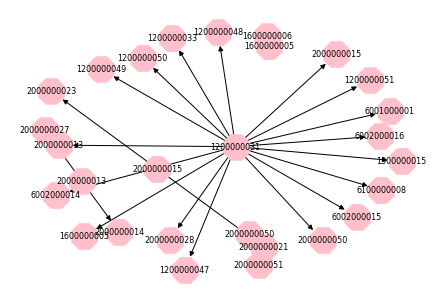

In [ ]:
g = nx.from_pandas_edgelist(patient_add, 'infected_by', 'patient_id', create_using = nx.DiGraph())
pos = nx.spring_layout(g, scale=2.0)
nx.draw(g, with_labels=True, node_color='pink',node_shape='8',
        node_size=800, font_size=8)

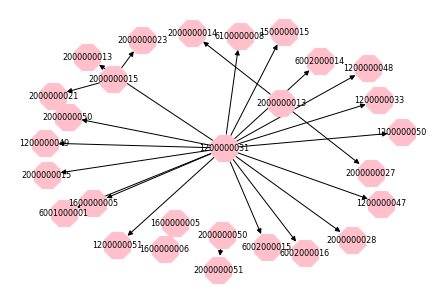

- 편의상 그림에서는 3차 감염자까지만 나타내었습니다.
- 31번 환자로 인해 감염된 사람들이 2차 감염자가 되어 3차 감염자를 만들어 내고 있습니다.
- 이 감염자들은 추후에 n차 감염자들을 양산해내었고, 전국적인 코로나 유행을 야기했습니다.

### 3. 이에 대한 정책으로 마스크 5부제 및 사회적거리두기를 시행했을 때의 효과를 살펴보자.

In [ ]:
# 각 일별 확진자 데이터 컬럼을 추가해줍니다.
Time = pd.read_csv('./Time.csv')
Time
Time['date'] = pd.to_datetime(Time['date'])
Time

def date_to_count(series):
    data=[0]
    for i in range(1,len(series)):
        data.append(series[i]-series[i-1])
    data =pd.DataFrame(data)
    return data
Time['confirmed_date'] = date_to_count(Time['confirmed'])
Time

,date,time,test,negative,confirmed,released,deceased,confirmed_date
0,2020-01-20,16,1,0,1,0,0,0
1,2020-01-21,16,1,0,1,0,0,0
2,2020-01-22,16,4,3,1,0,0,0
3,2020-01-23,16,22,21,1,0,0,0
4,2020-01-24,16,27,25,2,0,0,1
...,...,...,...,...,...,...,...,...
128,2020-05-27,0,852876,820550,11265,10295,269,40
129,2020-05-28,0,868666,834952,11344,10340,269,79
130,2020-05-29,0,885120,849161,11402,10363,269,58
131,2020-05-30,0,902901,865162,11441,10398,269,39


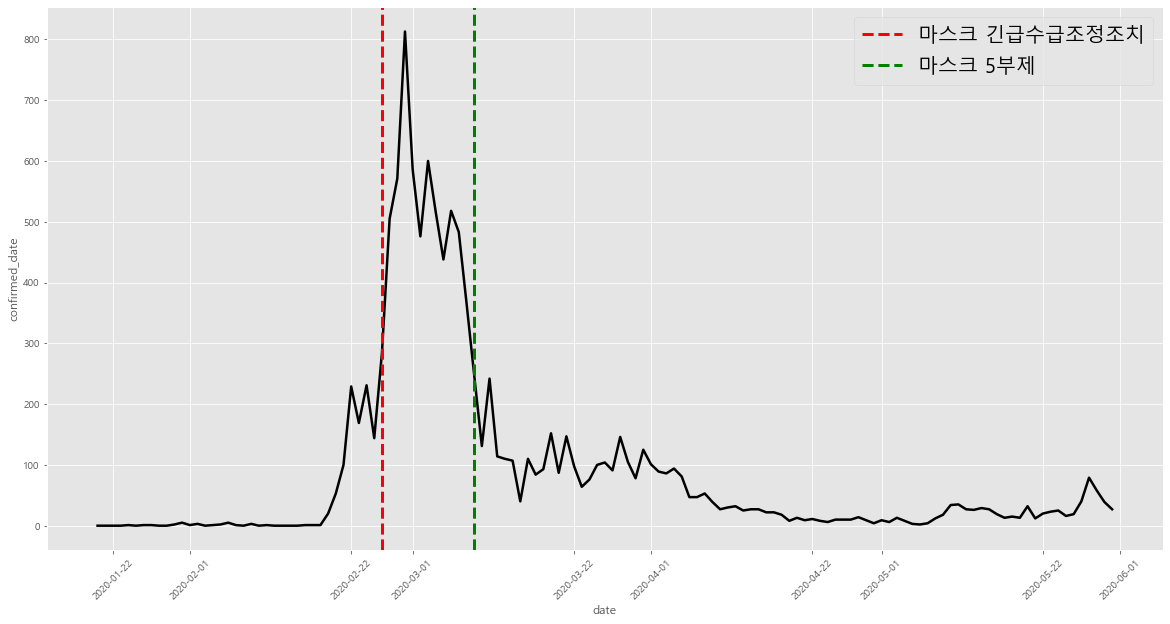

In [ ]:
from datetime import datetime
# 마스크 정책에 관한 그래프
plt.figure(figsize=(20,10))
sns.lineplot(x='date',y='confirmed_date',data=Time, palette="tab10", color='k', linewidth=2.5)
# 2020년 2월 26일부터 마스크 및 손소독제 긴급수급조정조치(마스크 수출금지, 마스크 생산량 50% 공직 판매처에 출고)
plt.axvline(x=datetime(2020, 2, 26), color='r', linestyle='--', linewidth=3,label="마스크 긴급수급조정조치")
# 2020년 3월 9일 마스크 5부제 시행
plt.axvline(x=datetime(2020, 3, 9), color='g', linestyle='--', linewidth=3,label="마스크 5부제")
plt.xticks(rotation=45)
plt.legend(fontsize=20)
plt.show()

- 코로나 확산세가 절정기이던 시절 거의 정확한 마스크 수급정책으로 인해 국민들의 마스크 접근이 용이해짐에 따라 큰 폭으로 확진자 수를 감소시킬 수 있었습니다.

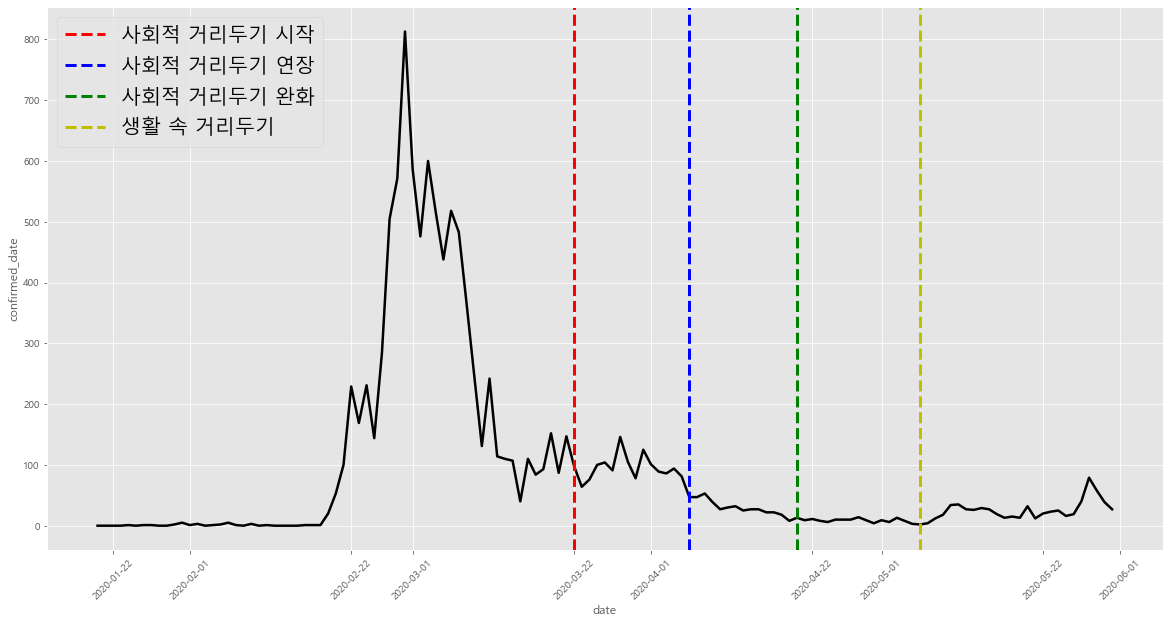

In [ ]:
# 사회적 거리두기의 효과를 나타내는 그래프

plt.figure(figsize=(20,10))
sns.lineplot(x='date',y='confirmed_date',data=Time, palette="tab10", color='k', linewidth=2.5)
# 2020년 3월 22일 부터 사회적 거리두기 정책을 시작합니다.
plt.axvline(x=datetime(2020, 3, 22), color='r', linestyle='--', linewidth=3,label="사회적 거리두기 시작")
# 원래는 2020년 4월 6일까지 사회적 거리두기 정책을 실시하기로 하였으나, 이를 4월 19일까지 연장합니다.
plt.axvline(x=datetime(2020, 4, 6), color='b', linestyle='--', linewidth=3, label="사회적 거리두기 연장")
# 4월 20일부터 5월 5일까지 다소 완화된 형태의 사회적 거리두기 정책을 시행합니다.
plt.axvline(x=datetime(2020, 4, 20), color='g', linestyle='--', linewidth=3, label="사회적 거리두기 완화")
# 코로나 확산세가 주춤하는 모습을 보이며 5월 6일부터 생활 속 거리두기(현재 사회적 거리두기 1단계) 체계로 전환화였습니다.
plt.axvline(x=datetime(2020, 5, 6), color='y', linestyle='--', linewidth=3, label="생활 속 거리두기")
# 이후 6월 28일부터 사회적 거리두기 정책을 1~3 단계로 구분하기 시작합니다.
plt.xticks(rotation=45)

plt.legend(fontsize=20)
plt.show()

- 2020년 3월 22일부터 시작된 사회적 거리두기 정책은 대구 지역에서 코로나19의 확산세가 진정된 이후에 실시됨으로 인해 정책 시기 상 조금 늦은 감이 없지 않아 있었습니다.

- 이러한 사회적 거리두기 정책은 기간을 연장함에 따라서 조금씩 확진자가 감소하는 효과를 보여주고 있습니다.

- 5월 6일 이후부터 시작된 생활 속 거리두기 정책(현 사회적 거리두기 1단계) 이후에도 잘 유지되는 모습을 보여주고 있습니다.

### 결론

- '신천지 집단감염'은, 31번 슈퍼 전파자로 인해 지역감염에서 전국적으로 확산되는데 많은 영향을 미쳤다.
- 이 확진자가 신천지 예배 당시 460명 가량의 사람들과 같은 공간에 있었다는 것이 문제가 되었다. 그리고 31번 확진자가 용인 사람임에도 대구에 예배를 드리러 갔다는 사실을 묵인한 채, 신도들이 아닌 사람들과도 접촉한 사실이 밝혀지면서 더 이슈가 되었다.
- 초기 '신천지 집단감염'의 근원지인 대구에서 신천지 교인들을 중심으로 대구 내 확진자 수가 급격하게 증가하였고,  슈퍼 전파자의 무책임한 행동으로 전국적으로 코로나 확산이 진행되었다.
- 정부에서는 '사회적 거리두기'와 '마스크 5부제' 정책을 발의하여 확진자 수를 줄이기 위해 노력했고, 코로나가 종식되는 분위기를 보이면서 '생활 속 거리두기' 이후에도 확진자 수가 안정적으로 유지되는 양상을 보여준다.
- 코로나 유행이 또 다시 시작되었을 때, 대구 신천지 집단감염 사건을 발판으로 더 빠른 대응을 할 수 있을 것이라 사료된다.